In [1]:
# For the purpose of this notebook, below blog post was referred
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
# Downloading nltk stopwords
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saiph\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Reading the Twitter Dataset

In [6]:
from os import listdir
from os.path import isfile, join

PATH = r"C:\Users\saiph\Desktop\Learning\Omdena\Coventry\\"

pkl_files = [f for f in listdir(PATH) if isfile(join(PATH, f)) and ".pkl" in f]

tweets_df = pd.DataFrame()

for pkl_file in pkl_files:
    temp_df = pd.read_pickle(pkl_file)
    tweets_df = tweets_df.append(temp_df)

tweets_df = tweets_df.reset_index(drop=True)

tweets_df.head()

,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,links
0,https://twitter.com/PaoloC_1/status/1470768091...,2021-12-14 14:50:13+00:00,@KBGreyhoundlady Amitriptyline is also a sedat...,@KBGreyhoundlady Amitriptyline is also a sedat...,1470768091550388238,"{'username': 'PaoloC_1', 'id': 602890495, 'dis...",1,0,2,0,...,None,1470653639475744768.0,"{'username': 'KBGreyhoundlady', 'id': 87308705...","[{'username': 'KBGreyhoundlady', 'id': 8730870...","{'longitude': -0.39216, 'latitude': 51.391383}","{'fullName': 'Richmond, London', 'name': 'Rich...",None,None,None,NaN
1,https://twitter.com/Celticheart72/status/14612...,2021-11-18 06:55:41+00:00,@shadyboots30 @SoIsFibroReal I take Amitriptyl...,@shadyboots30 @SoIsFibroReal I take Amitriptyl...,1461226587790131201,"{'username': 'Celticheart72', 'id': 27106696, ...",2,0,0,0,...,None,1460998876501061632.0,"{'username': 'shadyboots30', 'id': 2947749449,...","[{'username': 'shadyboots30', 'id': 2947749449...","{'longitude': -0.080028, 'latitude': 51.48432}","{'fullName': 'Poplar, London', 'name': 'Poplar...",None,None,None,NaN
2,https://twitter.com/Ed_Jabbari/status/14589322...,2021-11-11 22:58:49+00:00,"10mg Amitriptyline, 500mg Levetiracetam, 1g Me...","10mg Amitriptyline, 500mg Levetiracetam, 1g Me...",1458932254563053581,"{'username': 'Ed_Jabbari', 'id': 4326753748, '...",1,0,6,0,...,None,NaN,None,None,"{'longitude': -0.1420579, 'latitude': 51.5185518}","{'fullName': 'Islington, London', 'name': 'Isl...",None,None,None,NaN
3,https://twitter.com/LadyPandalorian/status/143...,2021-09-14 22:42:29+00:00,"@BrummyBoy13 ""Amitriptyline: a medicine used t...","@BrummyBoy13 ""Amitriptyline: a medicine used t...",1437909645255905290,"{'username': 'LadyPandalorian', 'id': 29456209...",1,0,1,0,...,None,1437909217655066624.0,"{'username': 'BrummyBoy13', 'id': 818923348847...","[{'username': 'BrummyBoy13', 'id': 81892334884...","{'longitude': -0.1114755, 'latitude': 51.4194247}","{'fullName': 'Camberwell, London', 'name': 'Ca...",None,None,{'title': 'Amitriptyline: a medicine used to t...,NaN
4,https://twitter.com/NichSmith/status/143631713...,2021-09-10 13:14:24+00:00,@_Widdershins_ @Joel32272266 @Hedgehog91_ @scr...,@_Widdershins_ @Joel32272266 @Hedgehog91_ @scr...,1436317134414614528,"{'username': 'NichSmith', 'id': 37434056, 'dis...",0,0,0,0,...,None,1436287854414548992.0,"{'username': '_Widdershins_', 'id': 1016349319...","[{'username': 'Joel32272266', 'id': 1387056644...","{'longitude': -0.15191, 'latitude': 51.410792}","{'fullName': 'Lambeth, London', 'name': 'Lambe...",None,None,None,NaN


In [7]:
tweets_df.shape, tweets_df.drop_duplicates(["id"]).shape

((42913, 29), (42404, 29))

In [8]:
tweets_df = tweets_df.drop_duplicates(["id"]).reset_index(drop=True)

In [9]:
i = 0
for tweet_content in tweets_df["content"]:
    if "Gestalt" in tweet_content:
        print(tweet_content)
i

@GestaltLondon
If you or your loved one is experiencing anxiety or depression, contact a #Gestalt therapist right away. Even if you are taking anti-anxiety or antidepressant pills, a few Gestalt sessions in addition to the pills might do wonders.


0

In [10]:
tweets_df.shape

(42404, 29)

In [11]:
# Importing Stopwords

from nltk.corpus import stopwords
stop_words = stopwords.words("english")

In [12]:
tweets_df["clean_tweet"] = tweets_df["content"].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x).split()))

In [13]:
tweets_df["clean_tweet"]

0        Amitriptyline is also a sedative prescribed fo...
1        I take Amitriptyline Pregabalin Lyrica Duloxet...
2        10mg Amitriptyline 500mg Levetiracetam 1g Meth...
3        Amitriptyline a medicine used to treat pain an...
4        Widdershins Might be Amitriptyline it gets use...
                               ...                        
42399    HappyNewYear everyone I m not a bore but I m w...
42400    Happy New Year Just asking have you any clue w...
42401    Incase anyone is still worried here s a beauti...
42402    Thanks Micheal I think I ve got no choice real...
42403    Booked mine too Have never been worried for my...
Name: clean_tweet, Length: 42404, dtype: object

# Tokenize words and Clean-up text

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [15]:
data_words = list(sent_to_words(tweets_df["clean_tweet"].values))

In [16]:
print(data_words[:1])

[['amitriptyline', 'is', 'also', 'sedative', 'prescribed', 'for', 'insomnia', 'so', 'wouldn', 'recommend', 'taking', 'it', 'during', 'the', 'day']]


# Creating Bigram and Trigram Models

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

In [18]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [19]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['amitriptyline', 'is', 'also', 'sedative', 'prescribed', 'for', 'insomnia', 'so', 'wouldn', 'recommend', 'taking', 'it', 'during', 'the', 'day']


# Remove Stopwords, Make Bigrams and Lemmatize

In [20]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [22]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [28]:
spacy.load('en_core_web_sm')

In [30]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [32]:
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['amitriptyline', 'also', 'sedative', 'prescribed', 'recommend', 'take', 'day']]


In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


# Building the Topic Model

In [34]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [35]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.200*"vaccine" + 0.130*"use" + 0.094*"child" + 0.088*"reach" + '
  '0.076*"change" + 0.040*"likely" + 0.035*"message" + 0.027*"impact" + '
  '0.026*"deal" + 0.023*"damage"'),
 (1,
  '0.240*"ask" + 0.092*"kid" + 0.056*"story" + 0.055*"late" + 0.054*"hospital" '
  '+ 0.051*"seriously" + 0.047*"local" + 0.027*"response" + 0.025*"usual" + '
  '0.025*"effect"'),
 (2,
  '0.185*"amp" + 0.120*"thank" + 0.111*"much" + 0.104*"thing" + 0.082*"start" '
  '+ 0.069*"first" + 0.058*"great" + 0.037*"point" + 0.025*"walk" + '
  '0.024*"fact"'),
 (3,
  '0.215*"right" + 0.127*"watch" + 0.090*"wait" + 0.065*"open" + 0.060*"head" '
  '+ 0.043*"word" + 0.039*"definitely" + 0.039*"can" + 0.037*"amazing" + '
  '0.032*"eye"'),
 (4,
  '0.233*"bit" + 0.132*"long" + 0.109*"friend" + 0.061*"hard" + 0.050*"follow" '
  '+ 0.038*"part" + 0.035*"low" + 0.029*"save" + 0.029*"amount" + '
  '0.021*"flat"'),
 (5,
  '0.219*"call" + 0.135*"seem" + 0.117*"must" + 0.045*"sort" + 0.044*"water" + '
  '0.043*"suffer" + 

In [36]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.416156134177406

Coherence Score:  0.29331818678792015


In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.318767  0.331699       1        1  17.061275
9     -0.095401 -0.060053       2        1  16.947365
18    -0.172378 -0.268609       3        1   8.805303
8     -0.136766 -0.129397       4        1   7.113794
2     -0.091451 -0.055687       5        1   6.739523
11    -0.092093 -0.056356       6        1   6.212905
12    -0.046371 -0.019344       7        1   5.215986
19    -0.001556  0.002162       8        1   4.641567
17    -0.012606 -0.002342       9        1   4.250078
15     0.023485  0.010352      10        1   3.391246
6      0.047894  0.016929      11        1   3.323166
4      0.062807  0.020178      12        1   2.960720
3      0.083313  0.023897      13        1   2.671142
16     0.074710  0.022388      14        1   2.511375
0      0.071496  0.021867      15        1   2.007782
1      0.103391  0.026812      16        1   1.637650
5      0.118797  0.028495      17        1   1.528921
13     0.111583  0.027715      18        1   1.185248
14     0.133025  0.029543      19        1   0.918066
10     0.136888  0.029749      20        1   0.876887, topic_info=        Term          Freq         Total Category  logprob  loglift
172      sad  23751.000000  23751.000000  Default  30.0000  30.0000
14       get  12555.000000  12555.000000  Default  29.0000  29.0000
103       go  11062.000000  11062.000000  Default  28.0000  28.0000
90    people   6272.000000   6272.000000  Default  27.0000  27.0000
64     think   5485.000000   5485.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
794      man      0.046087      1.633113  Topic20 -11.2262   1.1688
889     hear      0.046086      1.633162  Topic20 -11.2262   1.1688
2016    play      0.046086      1.633637  Topic20 -11.2262   1.1685
1043    show      0.046086      1.633615  Topic20 -11.2262   1.1685
795     miss      0.046086      1.632718  Topic20 -11.2262   1.1690

[1002 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
220       8  0.998249        able
193       6  0.997248  absolutely
305      10  0.989083       abuse
499       9  0.989825      access
524       9  0.988080         act
...     ...       ...         ...
388       3  0.998153       world
486       6  0.990009       worth
351       7  0.999723       would
153       9  0.999723        year
490       6  0.998675   yesterday

[375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 19, 9, 3, 12, 13, 20, 18, 16, 7, 5, 4, 17, 1, 2, 6, 14, 15, 11])

In [39]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [40]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

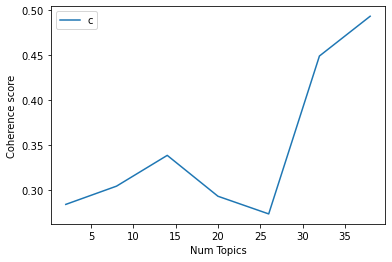

In [41]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2843
Num Topics = 8  has Coherence Value of 0.3045
Num Topics = 14  has Coherence Value of 0.3388
Num Topics = 20  has Coherence Value of 0.2933
Num Topics = 26  has Coherence Value of 0.2737
Num Topics = 32  has Coherence Value of 0.4492
Num Topics = 38  has Coherence Value of 0.4934
